In [12]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
from diffusers import DDPMScheduler
import os
import sys
sys.path.insert(1,"../scripts")
from get_voxels import collate_batch
from networks import EncoderCNN, UNet3D_ptcond
import torch
import torch.nn as nn
import torch.optim as optim


class EncoderCNN(nn.Module):
    def __init__(self, in_layers):
        super(EncoderCNN, self).__init__()
        self.pool = nn.MaxPool3d((2, 2, 2))
        self.relu = nn.ReLU()
        layers = []
        out_layers = 32

        for i in range(8):
            layers.append(nn.Conv3d(in_layers, out_layers, 3, bias=False, padding=1))
            layers.append(nn.BatchNorm3d(out_layers))
            layers.append(self.relu)
            in_layers = out_layers
            if (i + 1) % 2 == 0:
                # Duplicate number of layers every alternating layer.
                out_layers *= 2
                layers.append(self.pool)
        layers.pop()  # Remove the last max pooling layer!
        self.fc1 = nn.Linear(256, 512)
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.network(x)
        x = x.mean(dim=2).mean(dim=2).mean(dim=2)
        x = self.relu(self.fc1(x))
        return x

class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        trg_vocab_size,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len_t,
        device,
    ):
        super(Transformer, self).__init__()
        self.encoder = EncoderCNN(5)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len_t, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, trg):
        trg_seq_length, N = trg.shape

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)
        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out, embed_src, embed_trg

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

smiles = []
with open("../datasets/raw/zinc15_30000000.smi") as f:
    i=0
    for i, line in enumerate(f):
        smiles.append(line[:-1])
        if i > 10000000:
            break

batch_size = 8

smiles = smiles[batch_size*1000:]

class CustomImageDataset(Dataset):
    def __init__(self, smiles):
        self.smiles = smiles

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = self.smiles[idx]
        return smile

smile_DS = CustomImageDataset(smiles)

# Define the networks
net = UNet3D_ptcond(5,5)

net.load_state_dict(torch.load("../models/net_pharm_weights_32000.pkl"))
net.to(device)

enc = EncoderCNN(5)
enc.load_state_dict(torch.load("../models/encoderCNN_pharm_weights_32000.pkl"))
enc.to(device)

def create_batch(src, tar , batchsize , i):
    if ((i)*batchsize + batchsize) <= len(src):
        src, tar =  src[(i)*batchsize : (i)*batchsize + batchsize].T , tar[(i)*batchsize : (i)*batchsize + batchsize].T
    else:
        src, tar =  src[(i)*batchsize:].T , tar[(i)*batchsize :].T

    return torch.tensor(src).long(),torch.tensor(tar).long()

# Model hyperparameters
src_vocab_size = 64
trg_vocab_size = 29
embedding_size = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len_s = 512
max_len_t = 62
forward_expansion = 4
src_pad_idx = 0


# Training hyperparameters
num_epochs = 1
learning_rate = 3e-4
batch_size = 1

model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len_s,
    max_len_t,
    device,
).to(device)


# Training hyperparameters
num_epochs = 1
learning_rate = 3e-4
batch_size = 8


## Transformer training stuff
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True
)

pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).cuda()



#Other training stuff
train_dataloader = DataLoader(smile_DS, batch_size=batch_size, collate_fn=collate_batch)
scheduler = DDPMScheduler(num_train_timesteps=1000)



Using device: cuda


In [13]:
for i, (x, captions, pharm, lengths) in enumerate(train_dataloader):

    noise = torch.randn(x.shape).to(device)
    noisy_x  = scheduler.add_noise(x.to(device), noise, torch.stack([scheduler.timesteps[999]]*x.shape[0]).to(device))
    pred = net(noisy_x, torch.stack([scheduler.timesteps[999]]*x.shape[0]).to(device), pharm.to(device))
    encoded_reps = enc(pred)
    encoded_reps = (encoded_reps - encoded_reps.min()) / (encoded_reps.max() - encoded_reps.min()) * 63
    encoded_reps = encoded_reps.int()   

    src = encoded_reps.T.to(device)
    tar = captions.T.to(device)

    optimizer.zero_grad()
    output, a, b = model(src,tar)

    if i == 2:
        break

In [15]:
b.shape

torch.Size([62, 8, 512])

In [10]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len_s,
        max_len_t,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len_s, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len_t, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)
        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out, embed_src, embed_trg

In [9]:
_.shape

torch.Size([512, 8, 512])

In [2]:
x, captions, pharm, lengths = collate_batch(smiles[:128])

In [3]:
encoded_reps = []
batch_size = 16
for batch in range(int(len(x)/16)):
    encoded_reps.append(enc(x[batch*16:(batch+1)*16]))
encoded_reps = torch.cat(encoded_reps)
encoded_reps = (encoded_reps - encoded_reps.min()) / (encoded_reps.max() - encoded_reps.min()) * 63
encoded_reps = encoded_reps.int()


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        trg_vocab_size,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len_t,
        device,
    ):
        super(Transformer, self).__init__()
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len_t, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, trg):
        trg_seq_length, N = trg.shape

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)
        print(trg_mask)
        out = self.transformer(
            src,
            embed_trg,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out

In [36]:
# Model hyperparameters
trg_vocab_size = 29
embedding_size = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len_t = 62
forward_expansion = 4


In [41]:
# Training hyperparameters
num_epochs = 1
learning_rate = 3e-4
batch_size = 1

model = Transformer(
    embedding_size,
    trg_vocab_size,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len_t,
    device,
).to(device)

In [9]:
def create_batch(src, tar , batchsize , i):
    if ((i)*batchsize + batchsize) <= len(src):
        src, tar =  src[(i)*batchsize : (i)*batchsize + batchsize].T , tar[(i)*batchsize : (i)*batchsize + batchsize].T
    else:
        src, tar =  src[(i)*batchsize:].T , tar[(i)*batchsize :].T

    return torch.tensor(src).long(),torch.tensor(tar).long()

In [44]:
src,tar = create_batch(encoded_reps,captions, batch_size , 0)

/home/chris/miniconda3/envs/ligdream/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [45]:
model(src,tar)

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [28]:
model(src.reshape(1,1,512), tar)

RuntimeError: expected scalar type Long but found Float

In [22]:
encoded_src.shape

torch.Size([512, 1, 512])

In [9]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True
)

pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).cuda()

# Training hyperparameters
num_epochs = 10000
learning_rate = 3e-4
batch_size = 4

In [63]:
import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0
    start_time = time.time()
    for i in range(0,int(len(encoded_reps)/batch_size)):
        if i % 10 == 0:
            print(i)
        src,tar = create_batch(encoded_reps,captions, batch_size , i)
        src = src.to(device)
        tar = tar.to(device)
        optimizer.zero_grad()
        output = model(src,tar)
        loss = criterion(output.view(-1, output.shape[2]), tar.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        cur_loss = loss.item()
        total_loss += cur_loss
        log_interval = 100
        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                    's/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, i, (src.shape[1]) // batch_size, 
                    elapsed  / log_interval,
                    cur_loss, math.exp(cur_loss)))
            start_time = time.time()
    return total_loss

In [70]:
import math
for epoch in range(1, 3):
    epoch_start_time = time.time()
    loss = train()
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | Training loss {:5.2f} | '
          .format(epoch, (time.time() - epoch_start_time),
                                     loss))

0


/home/chris/miniconda3/envs/ligdream/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


10
20
30
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 16.26s | Training loss  0.02 | 
0
10
20
30
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 16.28s | Training loss  0.01 | 


In [71]:
src,tar = create_batch(encoded_reps,captions, 8 , 1)

/home/chris/miniconda3/envs/ligdream/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [72]:
output = model(src,torch.zeros(tar.shape, dtype=torch.long))

In [73]:
samples = torch.max(output.view(-1,output.shape[2]),1)[1].reshape(-1,8).T

In [74]:
vocab_list = ["pad", "start", "end",
    "C", "c", "N", "n", "S", "s", "P", "O", "o",
    "B", "F", "I",
    "Cl", "[nH]", "Br", # "X", "Y", "Z",
    "1", "2", "3", "4", "5", "6",
    "#", "=", "-", "(", ")"  # Misc
]

vocab_i2c_v1 = {i: x for i, x in enumerate(vocab_list)}
vocab_c2i_v1 = {vocab_i2c_v1[i]: i for i in vocab_i2c_v1}

RDKit ERROR: [17:20:19] SMILES Parse Error: extra close parentheses while parsing: CONnOO))O[nH]))N22[nH])
RDKit ERROR: [17:20:19] SMILES Parse Error: Failed parsing SMILES 'CONnOO))O[nH]))N22[nH])' for input: 'CONnOO))O[nH]))N22[nH])'
RDKit ERROR: [17:20:19] non-ring atom 3 marked aromatic
RDKit ERROR: [17:20:19] SMILES Parse Error: extra close parentheses while parsing: CNNnNOn)N)))N2[nH]22[nH]
RDKit ERROR: [17:20:19] SMILES Parse Error: Failed parsing SMILES 'CNNnNOn)N)))N2[nH]22[nH]' for input: 'CNNnNOn)N)))N2[nH]22[nH]'
RDKit ERROR: [17:20:19] SMILES Parse Error: extra close parentheses while parsing: CN(n)O))2)))N)2
RDKit ERROR: [17:20:19] SMILES Parse Error: Failed parsing SMILES 'CN(n)O))2)))N)2' for input: 'CN(n)O))2)))N)2'
RDKit ERROR: [17:20:19] SMILES Parse Error: extra close parentheses while parsing: CNNONO))2))2[nH])[nH]2)
RDKit ERROR: [17:20:19] SMILES Parse Error: Failed parsing SMILES 'CNNONO))2))2[nH])[nH]2)' for input: 'CNNONO))2))2[nH])[nH]2)'
RDKit ERROR: [17:20:1

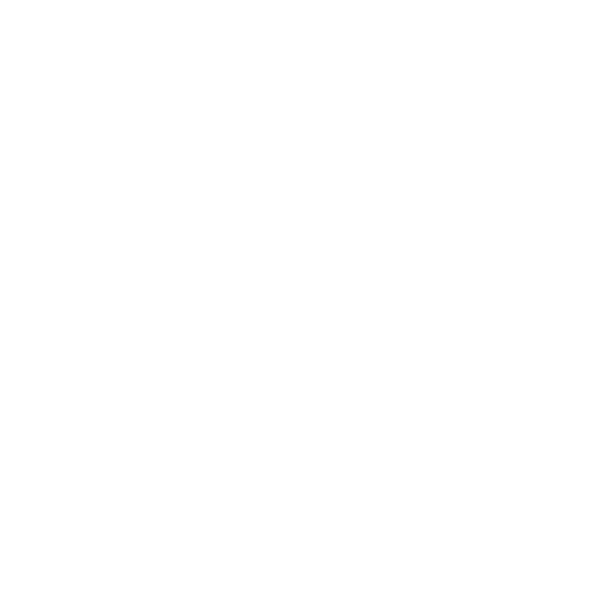

In [75]:
from rdkit.Chem import Draw
from rdkit import Chem
gen_smiles = []
for sample in samples:
    csmile = ""
    for xchar in sample[0:]:
        if xchar == 1:
            continue
        if xchar == 2:
            break
        csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
    gen_smiles.append(csmile)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in gen_smiles])

In [76]:
samples

tensor([[ 1,  3, 10,  5,  6, 10, 10, 28, 28, 10, 16, 28, 28,  5, 19, 19, 16, 28,
          2, 19,  2,  2, 19, 19, 16,  2, 19, 19,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2],
        [ 1,  3,  5,  5,  6,  2, 10, 28, 28, 28, 28, 28, 28, 16, 19,  6,  2, 19,
          6,  2, 16, 19,  2, 19, 16,  6, 16,  6,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2],
        [ 1,  3,  5,  5,  6,  5, 10,  6, 28,  5, 28, 28, 28,  5, 19, 16, 19, 19,
         16,  2, 28, 19, 19, 19, 16,  6, 16,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2],
        [ 1,  3,  5, 27,  6, 28, 10, 28, 28, 19, 28, 28, 28,  5, 28, 19,  2, 19,
          2, 28, 19, 19, 19, 19, 16,  6,  6,  2,  2,  2,  2,  2,

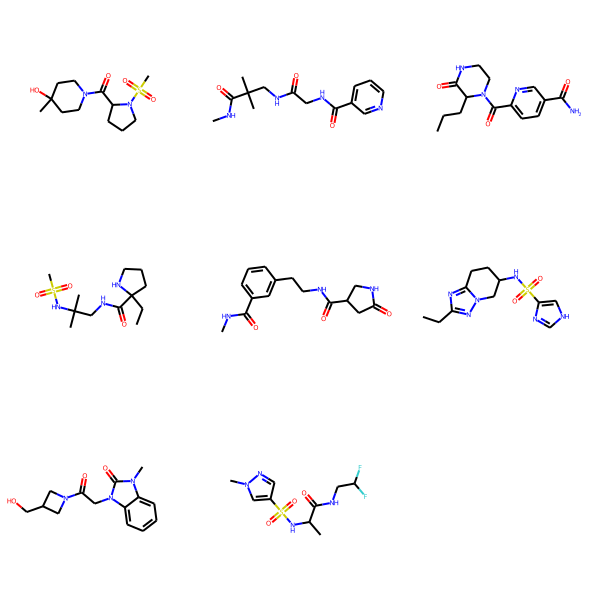

In [77]:
from rdkit.Chem import Draw
from rdkit import Chem
gen_smiles = []
for sample in tar.T:
    csmile = ""
    for xchar in sample[0:]:
        if xchar == 1:
            continue
        if xchar == 2:
            break
        csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
    gen_smiles.append(csmile)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in gen_smiles])